# Yarrowia Media Matrix 

### Takes generated media matrix and clusters groups for dimensionality reduction. Arbitrarily sets bounds and cluster groups, then uses LHS to sample points within bounds for initial experimental set.

#### this file is mostly copied from 'Yarrowia linear hierarchial tree reduction.ipynb' from ML_for_rational_design repo

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

from pyDOE3 import lhs
import torch

In [2]:
# read in g/L data for dimensional reduction 
df = pd.read_csv("data/Media-Matrix-Combined-v5-grams-per-litre.csv")

#df = pd.read_csv("data/Media-Matrix-Combined-v5-moles-per-litre.csv")  # uncomment this line to use mol/L version

# mol/L version will give same cluster results

# filter rows that are considered not important
compounds_to_remove = [
    'Dipotassium phosphate', 'Disodium edta dihydrate', 'EDTA', 'Monopotassium phosphate',
    'Phosphoric acid', 'Potassium hydroxide', 'Sodium citrate dihydrate', 'Sodium phosphate',
    'Sulphuric acid', 'Uracil'
]

df = df[~df['Compound'].isin(compounds_to_remove)].copy()

# remove pubchemid
df.drop(df.columns[1], axis=1, inplace=True)

# separate numeric columns for transformation
num_df = df.select_dtypes(include='number')
labels = df[['Compound', 'Annotate']]

yar_df = df.filter(like='_YAR')
#cer_df = df_log.filter(like='_CER')
#pic_df = df_log.filter(like='_PIC')

yar_df_labeled = pd.concat([labels, yar_df], axis=1)

# Define which columns are sample measurements (everything except metadata)
sample_cols = yar_df_labeled.columns.difference(['Compound', 'Annotate'])

# Filter to keep rows where at least one sample value ≠ 0   # this bit was changed for the linear version of this process pipeline
yar_df_labeled = yar_df_labeled[
    yar_df_labeled['Annotate'].isin(['Vitamin', 'Element']) &
    ~(yar_df_labeled[sample_cols] == 0).all(axis=1)
].copy()

# let's remove redundant elements for calcium iron, manganese, sodium chloride and zinc chloride
yar_df_labeled = yar_df_labeled.drop(index=[9, 16, 29, 35, 46, 59])

yar_df_element = yar_df_labeled[yar_df_labeled['Annotate'] == 'Element'].copy()
yar_df_vitamin = yar_df_labeled[yar_df_labeled['Annotate'] == 'Vitamin'].copy()


Eleements hierarchical tree:

Using adpative eps = 4.59e-09


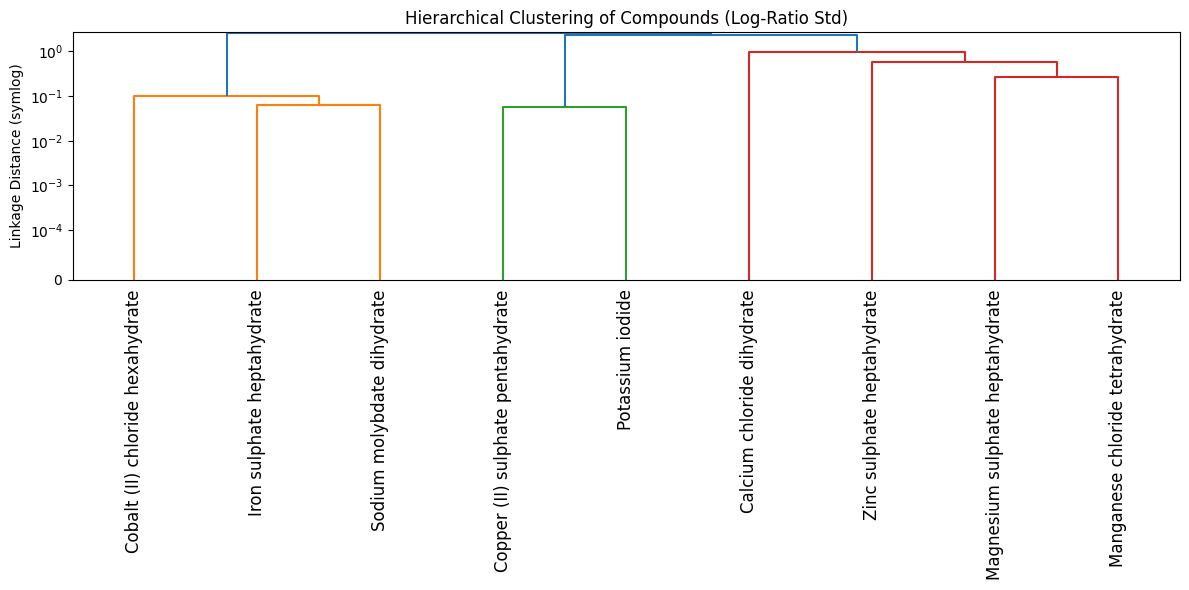

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_26172\2403948979.py:94: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vals = row[sample_cols].replace(0, np.nan)  # ignore zeros


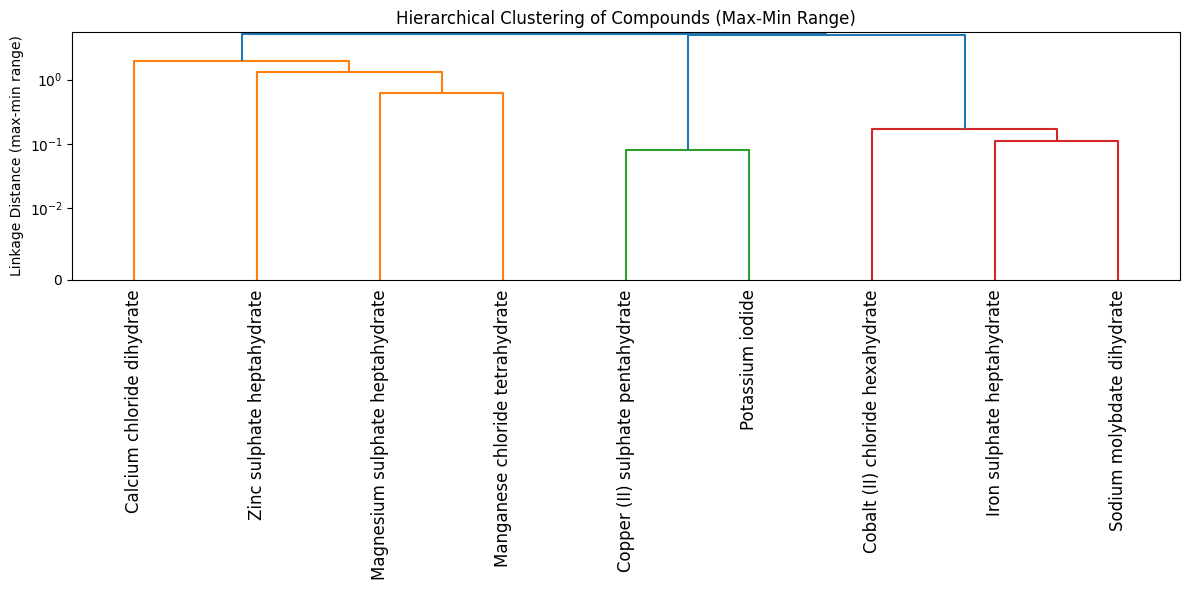

 Step  Cluster_ID                                                                           Merged_Cluster_1                                                                                                                                                                Merged_Cluster_2  Linkage_Distance  Num_Compounds
    1           9                                                        [Copper (II) sulphate pentahydrate]                                                                                                                                                              [Potassium iodide]          0.056001              2
    2          10                                                               [Iron sulphate heptahydrate]                                                                                                                                                    [Sodium molybdate dihydrate]          0.063014              2
    3          11                             

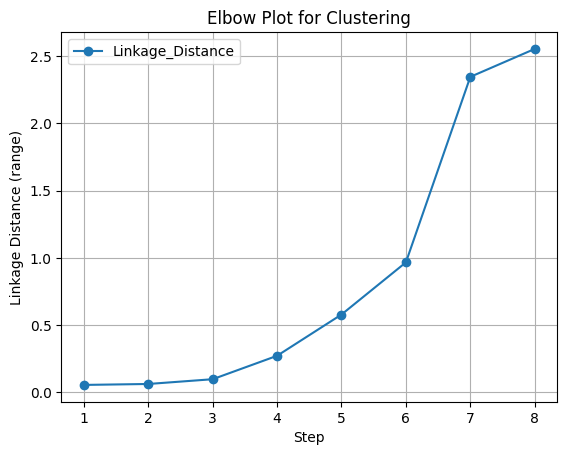

In [4]:
# -------------------------------
# Step 0: Prepare data
# -------------------------------
df_e = yar_df_element.copy()

df_e = df_e.sample(frac=1)  # shuffle rows for randomness
sample_cols = df_e.columns.difference(['Compound', 'Annotate'])

# Adaptive eps adds a small value based on the minimum non-zero value in the dataset
min_nonzero = df_e[sample_cols].replace(0, np.nan).min().min()
eps = min_nonzero*1e-3
# This keeps clustering constant across runs
print(f"Using adpative eps = {eps:.2e}")

# -------------------------------
# Step 1: Compute log-ratio distances
# -------------------------------
ratios = []

# All unique compound pairs
compound_pairs = list(itertools.combinations(df_e['Compound'], 2))

# Map for quick lookup
compound_map = df_e.set_index('Compound')[sample_cols]

for c1, c2 in compound_pairs:
    vals1 = compound_map.loc[c1]
    vals2 = compound_map.loc[c2]

    # log-ratio with pseudocount
    ratio = np.log10(vals1 + eps) - np.log10(vals2 + eps)
    
    # absolute value (fold difference)
    ratio = ratio.abs()
    
    # if all NaN or zero, replace with small value to avoid exact zero distance
    if ratio.notna().sum() == 0:
        ratio[:] = eps

    row = {'Compound_1': c1, 'Compound_2': c2, **ratio.to_dict()}
    ratios.append(row)

ratio_df_e = pd.DataFrame(ratios)

# Drop irrelevant columns
ratio_df_e_reduced = ratio_df_e.drop(columns=['1_YAR','2b_YAR','2c_YAR','2d_YAR','3b_YAR','3c_YAR','6_YAR'], errors='ignore')

# -------------------------------
# Step 2: Compute SD per pair
# -------------------------------
sample_cols = ratio_df_e_reduced.columns.difference(['Compound_1', 'Compound_2'])
ratio_df_e_reduced['Std_Ratio'] = ratio_df_e_reduced[sample_cols].replace(0, np.nan).std(axis=1, skipna=True).fillna(0)

# -------------------------------
# Step 3: Build distance matrix
# -------------------------------
compounds = pd.unique(ratio_df_e_reduced[['Compound_1', 'Compound_2']].values.ravel())
distance_matrix = pd.DataFrame(0, index=compounds, columns=compounds, dtype=float)

for _, row in ratio_df_e_reduced.iterrows():
    c1, c2, std = row['Compound_1'], row['Compound_2'], row['Std_Ratio']
    distance_matrix.loc[c1, c2] = std
    distance_matrix.loc[c2, c1] = std

np.fill_diagonal(distance_matrix.values, 0)

# -------------------------------
# Step 4: Hierarchical clustering
# -------------------------------
# Convert to condensed distance matrix
condensed_dist = squareform(distance_matrix.values)

# Use average linkage
Z = linkage(condensed_dist, method='average')

# -------------------------------
# Step 5: Plot dendrogram
# -------------------------------
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=distance_matrix.index.tolist(), leaf_rotation=90)
plt.yscale('symlog', linthresh=.0001)
plt.ylabel("Linkage Distance (symlog)")
plt.title("Hierarchical Clustering of Compounds (Log-Ratio Std)")
plt.tight_layout()
plt.show()

'''Same thing as std above but for max-min range ratios'''
# -------------------------------
# Step 1: Compute max-min distances per pair
# -------------------------------
range_values = []

for _, row in ratio_df_e_reduced.iterrows():
    vals = row[sample_cols].replace(0, np.nan)  # ignore zeros
    if vals.notna().sum() == 0:
        rng = eps  # avoid NaNs and treats as small distance
    else:
        rng = vals.max() - vals.min()
        if rng == 0:
            rng = eps # gives tiny separation if all values are the same
    range_values.append(rng)

ratio_df_e_reduced['Range'] = range_values

# -------------------------------
# Step 2: Build distance matrix
# -------------------------------
distance_matrix_range = pd.DataFrame(0, index=compounds, columns=compounds, dtype=float)

for _, row in ratio_df_e_reduced.iterrows():
    c1, c2, rng = row['Compound_1'], row['Compound_2'], row['Range']
    distance_matrix_range.loc[c1, c2] = rng
    distance_matrix_range.loc[c2, c1] = rng

np.fill_diagonal(distance_matrix_range.values, 0)

# -------------------------------
# Step 3: Hierarchical clustering
# -------------------------------
condensed_dist_range = squareform(distance_matrix_range.values)
Z_range = linkage(condensed_dist_range, method='average')

# -------------------------------
# Step 4: Plot dendrogram
# -------------------------------
plt.figure(figsize=(12, 6))
dendrogram(Z_range, labels=distance_matrix_range.index.tolist(), leaf_rotation=90)
plt.yscale('symlog', linthresh=0.01)
plt.ylabel("Linkage Distance (max-min range)")
plt.title("Hierarchical Clustering of Compounds (Max-Min Range)")
plt.tight_layout()
plt.show()

'''this bit generates the merge table for the hierarchical clustering'''
# Get compound names
compounds = list(distance_matrix.index)

# Number of original observations
n = len(compounds)

# This will store merge history
merge_history = []

# Track cluster membership (compound names or merged groups)
clusters = {i: [compounds[i]] for i in range(n)}

# Loop over linkage matrix Z
for step, (idx1, idx2, dist, sample_count) in enumerate(Z):
    idx1, idx2 = int(idx1), int(idx2)
    
    # Get the clusters being merged
    members1 = clusters[idx1]
    members2 = clusters[idx2]

    # Merge the two clusters
    new_cluster = members1 + members2
    clusters[n + step] = new_cluster

    # Save merge info
    merge_history.append({
        'Step': step + 1,
        'Cluster_ID': n + step,
        'Merged_Cluster_1': members1,
        'Merged_Cluster_2': members2,
        'Linkage_Distance': dist,
        'Num_Compounds': len(new_cluster),
    })

# Convert to dataframe for easier viewing
merge_df = pd.DataFrame(merge_history)

# Display the merge table sorted by step (or by distance, if you prefer)
merge_df_sorted = merge_df.sort_values('Linkage_Distance', ascending=True)

# Print the table or write to CSV
print(merge_df_sorted.to_string(index=False))

merge_df_sorted[['Step', 'Linkage_Distance']].plot(x='Step', y='Linkage_Distance', marker='o')
plt.ylabel("Linkage Distance (range)")
plt.title("Elbow Plot for Clustering")
plt.grid(True)
plt.show()

Vitamin hierarchical tree (same as above which was for elements)

Using adpative eps = 7.50e-11


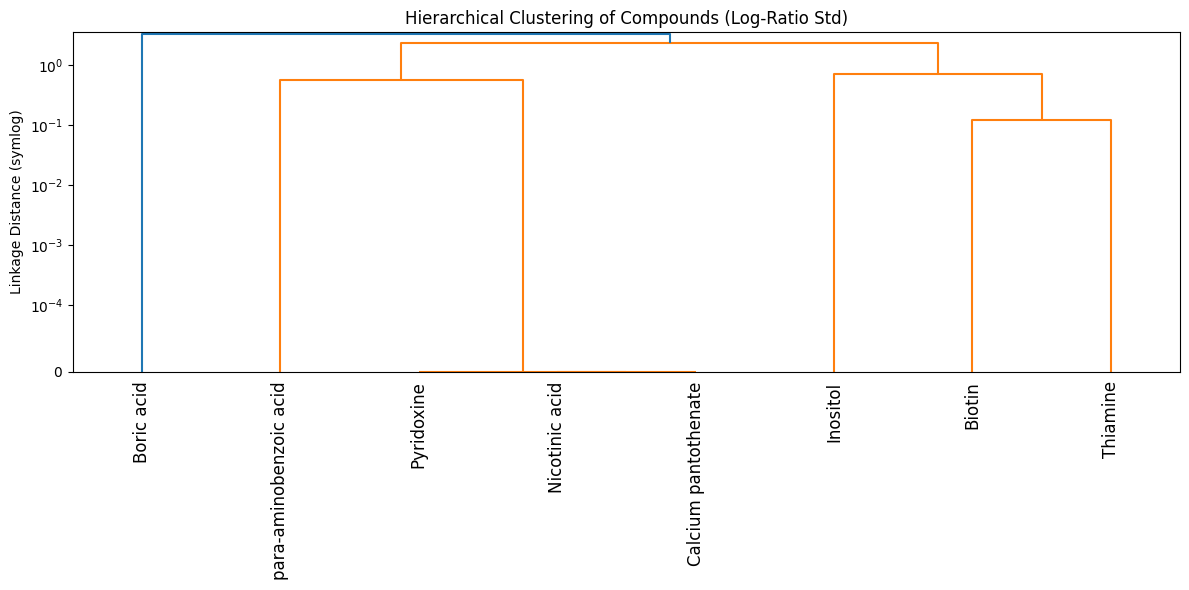

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_26172\2545492560.py:96: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vals = row[sample_cols].replace(0, np.nan)  # ignore zeros


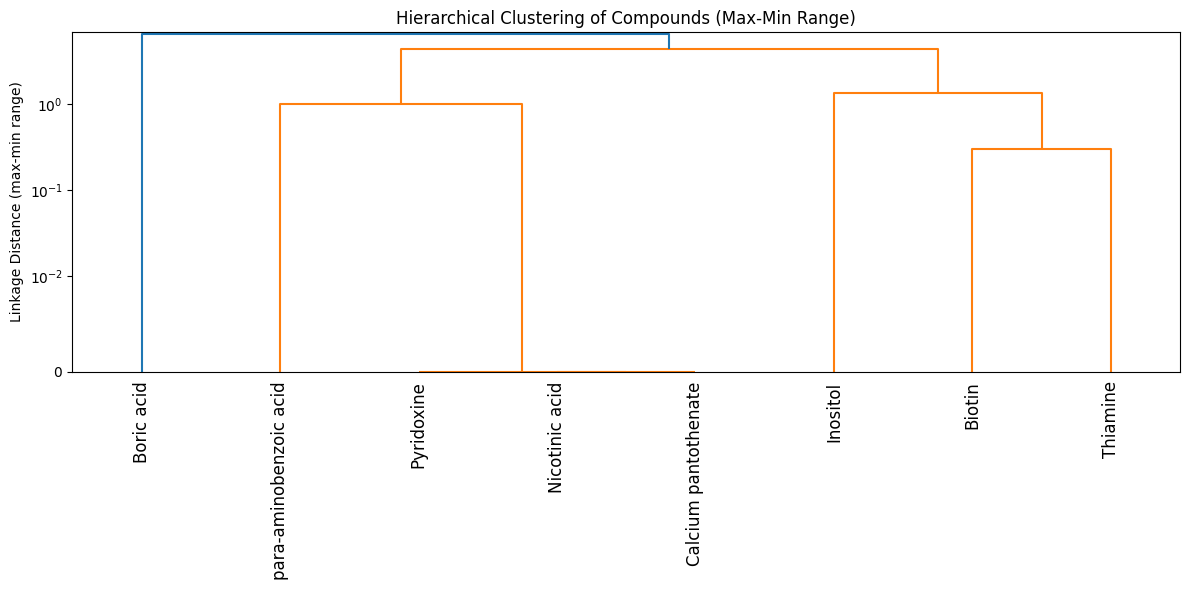

 Step  Cluster_ID                                                           Merged_Cluster_1                                                                                       Merged_Cluster_2  Linkage_Distance  Num_Compounds
    1           8                                                           [Nicotinic acid]                                                                                 [Calcium pantothenate]      0.000000e+00              2
    2           9                                                               [Pyridoxine]                                                                 [Nicotinic acid, Calcium pantothenate]      4.007229e-09              3
    3          10                                                                   [Biotin]                                                                                             [Thiamine]      1.205431e-01              2
    4          11                                                   [para-aminobenzo

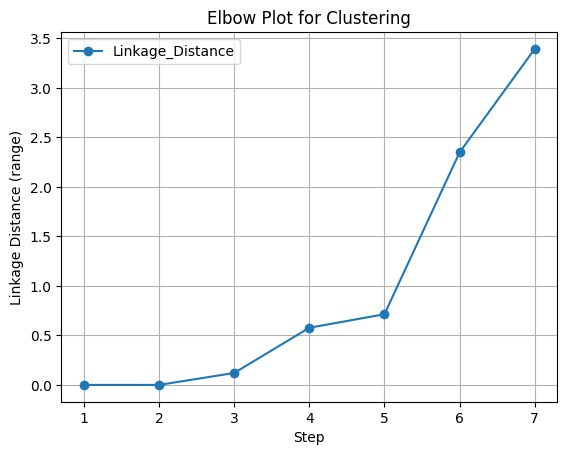

In [5]:
# -------------------------------
# Step 0: Prepare data
# -------------------------------
df_v = yar_df_vitamin.copy()

df_v = df_v.sample(frac=1)  # shuffle rows for randomness
sample_cols = df_v.columns.difference(['Compound', 'Annotate'])



# Adaptive eps adds a small value based on the minimum non-zero value in the dataset
min_nonzero = df_v[sample_cols].replace(0, np.nan).min().min()
eps = min_nonzero*1e-3
# This prevents frac=1 from changing the clustering results
print(f"Using adpative eps = {eps:.2e}")

# -------------------------------
# Step 1: Compute log-ratio distances
# -------------------------------
ratios = []

# All unique compound pairs
compound_pairs = list(itertools.combinations(df_v['Compound'], 2))

# Map for quick lookup
compound_map = df_v.set_index('Compound')[sample_cols]

for c1, c2 in compound_pairs:
    vals1 = compound_map.loc[c1]
    vals2 = compound_map.loc[c2]

    # log-ratio with pseudocount
    ratio = np.log10(vals1 + eps) - np.log10(vals2 + eps)
    
    # absolute value (fold difference)
    ratio = ratio.abs()
    
    # if all NaN or zero, replace with small value to avoid exact zero distance
    if ratio.notna().sum() == 0:
        ratio[:] = eps

    row = {'Compound_1': c1, 'Compound_2': c2, **ratio.to_dict()}
    ratios.append(row)

ratio_df_v = pd.DataFrame(ratios)

# Drop irrelevant columns
ratio_df_v_reduced = ratio_df_v.drop(columns=['1_YAR','2b_YAR','2c_YAR','2d_YAR','3c_YAR','6_YAR'], errors='ignore')

# -------------------------------
# Step 2: Compute SD per pair
# -------------------------------
sample_cols = ratio_df_v_reduced.columns.difference(['Compound_1', 'Compound_2'])
ratio_df_v_reduced['Std_Ratio'] = ratio_df_v_reduced[sample_cols].replace(0, np.nan).std(axis=1, skipna=True).fillna(0)

# -------------------------------
# Step 3: Build distance matrix
# -------------------------------
compounds = pd.unique(ratio_df_v_reduced[['Compound_1', 'Compound_2']].values.ravel())
distance_matrix = pd.DataFrame(0, index=compounds, columns=compounds, dtype=float)

for _, row in ratio_df_v_reduced.iterrows():
    c1, c2, std = row['Compound_1'], row['Compound_2'], row['Std_Ratio']
    distance_matrix.loc[c1, c2] = std
    distance_matrix.loc[c2, c1] = std

np.fill_diagonal(distance_matrix.values, 0)

# -------------------------------
# Step 4: Hierarchical clustering
# -------------------------------
# Convert to condensed distance matrix
condensed_dist = squareform(distance_matrix.values)

# Use average linkage
Z = linkage(condensed_dist, method='average')

# -------------------------------
# Step 5: Plot dendrogram
# -------------------------------
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=distance_matrix.index.tolist(), leaf_rotation=90)
plt.yscale('symlog', linthresh=.0001)
plt.ylabel("Linkage Distance (symlog)")
plt.title("Hierarchical Clustering of Compounds (Log-Ratio Std)")
plt.tight_layout()
plt.show()

'''Same thing as std above but for max-min range ratios'''
# -------------------------------
# Step 1: Compute max-min distances per pair
# -------------------------------
range_values = []

for _, row in ratio_df_v_reduced.iterrows():
    vals = row[sample_cols].replace(0, np.nan)  # ignore zeros
    if vals.notna().sum() == 0:
        rng = eps  # avoid NaNs and treats as small distance
    else:
        rng = vals.max() - vals.min()
        if rng == 0:
            rng = eps # gives tiny separation if all values are the same
    range_values.append(rng)

ratio_df_v_reduced['Range'] = range_values

# -------------------------------
# Step 2: Build distance matrix
# -------------------------------
distance_matrix_range = pd.DataFrame(0, index=compounds, columns=compounds, dtype=float)

for _, row in ratio_df_v_reduced.iterrows():
    c1, c2, rng = row['Compound_1'], row['Compound_2'], row['Range']
    distance_matrix_range.loc[c1, c2] = rng
    distance_matrix_range.loc[c2, c1] = rng

np.fill_diagonal(distance_matrix_range.values, 0)

# -------------------------------
# Step 3: Hierarchical clustering
# -------------------------------
condensed_dist_range = squareform(distance_matrix_range.values)
Z_range = linkage(condensed_dist_range, method='average')

# -------------------------------
# Step 4: Plot dendrogram
# -------------------------------
plt.figure(figsize=(12, 6))
dendrogram(Z_range, labels=distance_matrix_range.index.tolist(), leaf_rotation=90)
plt.yscale('symlog', linthresh=0.01)
plt.ylabel("Linkage Distance (max-min range)")
plt.title("Hierarchical Clustering of Compounds (Max-Min Range)")
plt.tight_layout()
plt.show()


'''this bit generates the merge table for the hierarchical clustering'''
# Get compound names
compounds = list(distance_matrix.index)

# Number of original observations
n = len(compounds)

# This will store merge history
merge_history = []

# Track cluster membership (compound names or merged groups)
clusters = {i: [compounds[i]] for i in range(n)}

# Loop over linkage matrix Z
for step, (idx1, idx2, dist, sample_count) in enumerate(Z):
    idx1, idx2 = int(idx1), int(idx2)
    
    # Get the clusters being merged
    members1 = clusters[idx1]
    members2 = clusters[idx2]

    # Merge the two clusters
    new_cluster = members1 + members2
    clusters[n + step] = new_cluster

    # Save merge info
    merge_history.append({
        'Step': step + 1,
        'Cluster_ID': n + step,
        'Merged_Cluster_1': members1,
        'Merged_Cluster_2': members2,
        'Linkage_Distance': dist,
        'Num_Compounds': len(new_cluster),
    })

# Convert to dataframe for easier viewing
merge_df = pd.DataFrame(merge_history)

# Display the merge table sorted by step (or by distance, if you prefer)
merge_df_sorted = merge_df.sort_values('Linkage_Distance', ascending=True)

# Print the table or write to CSV
print(merge_df_sorted.to_string(index=False))

merge_df_sorted[['Step', 'Linkage_Distance']].plot(x='Step', y='Linkage_Distance', marker='o')
plt.ylabel("Linkage Distance (range)")
plt.title("Elbow Plot for Clustering")
plt.grid(True)
plt.show()

# Alpha generator 1.1 and tool for clustering reduction, converting between raw and transfored data, and generating BO boundaries

## Alpha generator has been updated to choose expanded min max bounds

In [6]:
class ClusterScaler:
    def __init__(self, df, cluster_compounds):
        """
        Args:
            df (pd.DataFrame): Must contain 'Compound', 'Min', 'Max', and 'Median' columns
            cluster_compounds (list of str): List of compounds to include in this cluster
        """
        self.df = df.set_index("Compound")
        self.compounds = cluster_compounds

        # Pull stats
        self.medians = self.df.loc[self.compounds, "Median"].to_dict()

        # use expaned bounds if available, otherwise use original min/max
        if 'Expanded_Min' in self.df.columns and 'Expanded_Max' in self.df.columns:
            self.mins = self.df.loc[self.compounds, "Expanded_Min"].to_dict()
            self.maxs = self.df.loc[self.compounds, "Expanded_Max"].to_dict()
        else:
            self.mins = self.df.loc[self.compounds, "Min"].to_dict()
            self.maxs = self.df.loc[self.compounds, "Max"].to_dict()

        # Log10 of medians
        self.log10_medians = {k: np.log10(v) for k, v in self.medians.items()}
        self.mean_log10 = np.mean(list(self.log10_medians.values()))

        # Offsets c_i
        self.offsets = {k: v - self.mean_log10 for k, v in self.log10_medians.items()}

    def log_concentration_from_alpha(self, alpha):
        return {compound: alpha + offset for compound, offset in self.offsets.items()}

    def concentration_from_alpha(self, alpha):
        return {compound: 10**(alpha + offset) for compound, offset in self.offsets.items()}

    def solve_alpha_for_target(self, compound, target_concentration):
        if compound not in self.offsets:
            raise ValueError(f"Compound '{compound}' not in this cluster.")
        return np.log10(target_concentration) - self.offsets[compound]

    def get_alpha_bounds(self):
        alpha_mins = []
        alpha_maxs = []

        for compound in self.compounds:
            c_i = self.offsets[compound]
            min_val = self.mins[compound]
            max_val = self.maxs[compound]
            alpha_min_i = np.log10(min_val) - c_i
            alpha_max_i = np.log10(max_val) - c_i
            alpha_mins.append(alpha_min_i)
            alpha_maxs.append(alpha_max_i)

        alpha_min = min(alpha_mins)
        alpha_max = max(alpha_maxs)

        if alpha_min > alpha_max:
            raise ValueError("No valid alpha range — bounds conflict between compounds.")

        return alpha_min, alpha_max

In [8]:
# this allows for min max range extraction for elements and vitamins for the plots below
df_e_reduced = df_e.drop(columns = ['1_YAR', '2b_YAR', '2c_YAR', '2d_YAR', '3b_YAR', '3c_YAR', '6_YAR']) 

df_e_reduced_nan = df_e_reduced.replace(0, np.nan) # replace 0 with Nans so correct min can be extracted
#selects numeric columns only
numeric_cols_e = df_e_reduced_nan.select_dtypes(include=[np.number]).columns


# Compute min and max for each compound, excluding NaNs
min_values = df_e_reduced_nan[numeric_cols_e].min(axis=1, skipna=True)
max_values = df_e_reduced_nan[numeric_cols_e].max(axis=1, skipna=True)
median_values = df_e_reduced_nan[numeric_cols_e].median(axis=1, skipna = True)
mean_values = df_e_reduced_nan[numeric_cols_e].mean(axis=1, skipna = True)

# Create a new dataframe with Compound, Min, and Max
df_e_min_max = pd.DataFrame({
    'Compound': df_e_reduced_nan['Compound'],
    'Min': min_values,
    'Max': max_values,
    'Median': median_values,
    'Mean': mean_values
})

# ========== Vitamin section below ==========

df_v_reduced = df_v.drop(columns=['1_YAR','2b_YAR', '2c_YAR', '2d_YAR', '3c_YAR', '6_YAR'])

df_v_reduced_nan = df_v_reduced.replace(0, np.nan) # replace 0 with Nans so correct min can be extracted

#selects numeric columns only
numeric_cols_v = df_v_reduced_nan.select_dtypes(include=[np.number]).columns

# Compute min and max for each compound, excluding NaNs
min_values = df_v_reduced_nan[numeric_cols_v].min(axis=1, skipna=True)
max_values = df_v_reduced_nan[numeric_cols_v].max(axis=1, skipna=True)
median_values = df_v_reduced_nan[numeric_cols_v].median(axis=1, skipna = True)
mean_values = df_v_reduced_nan[numeric_cols_v].mean(axis=1, skipna = True)

# Create a new dataframe with Compound, Min, and Max
df_v_min_max = pd.DataFrame({
    'Compound': df_v_reduced_nan['Compound'],
    'Min': min_values,
    'Max': max_values,
    'Median': median_values,
    'Mean': mean_values
})

In [9]:

def expand_bounds(min_val, max_val, percent=0.1):
    expanded_min = min_val / (1 + percent)
    expanded_max = max_val * (1 + percent)
    return expanded_min, expanded_max


# Apply the expansion row-wise

df_e_min_max[['Expanded_Min', 'Expanded_Max']] = df_e_min_max.apply(
    lambda row: pd.Series(expand_bounds(row['Min'], row['Max'])),
    axis=1
)

df_v_min_max[['Expanded_Min', 'Expanded_Max']] = df_v_min_max.apply(
    lambda row: pd.Series(expand_bounds(row['Min'], row['Max'])),
    axis=1
)

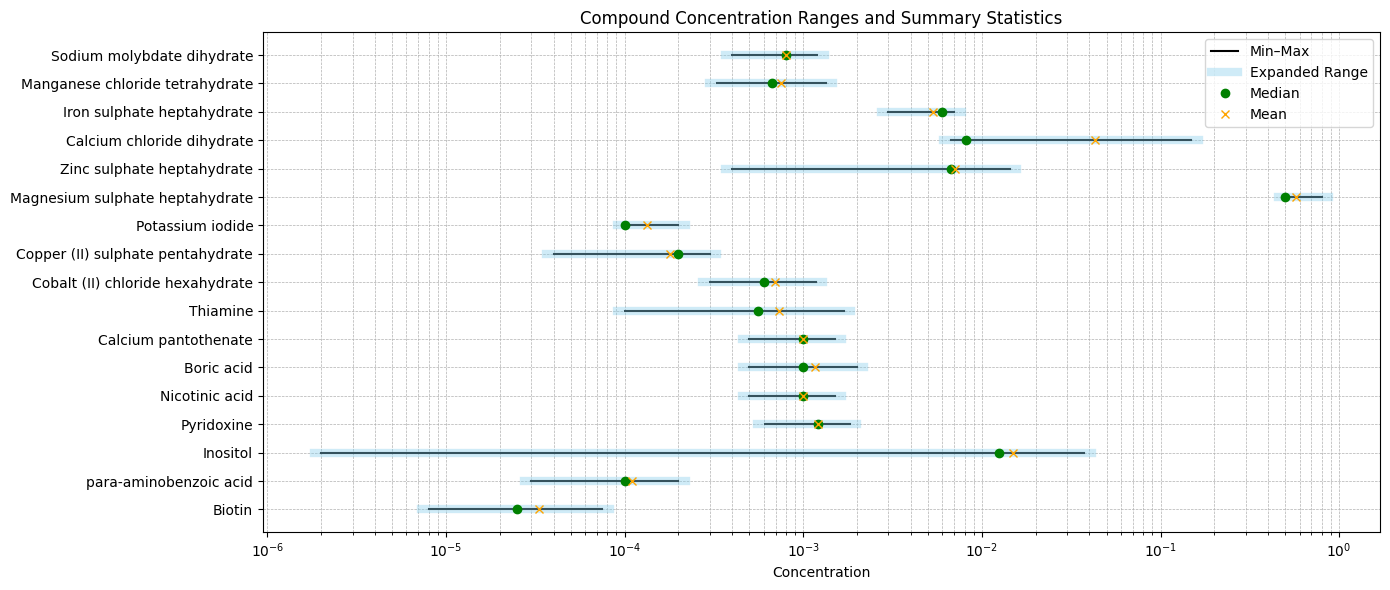

In [11]:
df_all = pd.concat([df_v_min_max, df_e_min_max], ignore_index=True)
# Sort compounds by median or mean for clean axis ordering
df_sorted = df_all#.sort_values(by='Median')

plt.figure(figsize=(14, 6))

for i, row in enumerate(df_sorted.itertuples()):
    y = i
    
    # Plot original Min–Max as a narrow line
    plt.plot([row.Min, row.Max], [y, y], color='black', lw=1.5, label='Min–Max' if i == 0 else "")

    # Plot expanded range as a thick semi-transparent bar
    plt.plot([row.Expanded_Min, row.Expanded_Max], [y, y], color='skyblue', lw=6, alpha=0.4, label='Expanded Range' if i == 0 else "")
    
    # Mark median and mean
    plt.plot(row.Median, y, 'o', color='green', label='Median' if i == 0 else "")
    plt.plot(row.Mean, y, 'x', color='orange', label='Mean' if i == 0 else "")

plt.yticks(range(len(df_sorted)), df_sorted['Compound'])
plt.xlabel("Concentration")
plt.title("Compound Concentration Ranges and Summary Statistics")
plt.legend(loc='upper right')
plt.xscale('log')  # for comparability across orders of magnitude
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [14]:
# cluster order here is arbitrary, but we want separate scalers for conversion when transforming data

#This is the old clusters before Haxby found some flaws in the code
'''
cluster_e1 = ['Copper (II) sulphate pentahydrate', 'Manganese chloride tetrahydrate']
scaler_e1 = ClusterScaler(df_e_min_max, cluster_e1)

cluster_e2 = ['Cobalt (II) chloride hexahydrate', 'Iron sulphate heptahydrate', 'Potassium iodide']
scaler_e2 = ClusterScaler(df_e_min_max, cluster_e2)

cluster_e3 = ['Magnesium sulphate heptahydrate', 'Sodium molybdate dihydrate', 'Zinc sulphate heptahydrate']
scaler_e3 = ClusterScaler(df_e_min_max, cluster_e3)

cluster_v1 = ['Nicotinic acid', 'Boric acid', 'Calcium pantothenate']
scaler_v1 = ClusterScaler(df_v_min_max, cluster_v1)

cluster_v2 = ['Biotin', 'Pyridoxine']
scaler_v2 = ClusterScaler(df_v_min_max, cluster_v2)
'''

# ---------------- Elements ----------------
cluster_e1 = ['Potassium iodide', 'Copper (II) sulphate pentahydrate']
scaler_e1 = ClusterScaler(df_e_min_max, cluster_e1)

cluster_e2 = ['Iron sulphate heptahydrate', 'Sodium molybdate dihydrate', 'Cobalt (II) chloride hexahydrate']
scaler_e2 = ClusterScaler(df_e_min_max, cluster_e2)

cluster_e3 = ['Magnesium sulphate heptahydrate', 'Manganese chloride tetrahydrate']#, 'Zinc sulphate heptahydrate']#, 'Calcium chloride dihydrate']
scaler_e3 = ClusterScaler(df_e_min_max, cluster_e3)

# ---------------- Vitamins ----------------
cluster_v1 = ['Nicotinic acid', 'Calcium pantothenate', 'Pyridoxine']
scaler_v1 = ClusterScaler(df_v_min_max, cluster_v1)

cluster_v2 = ['Biotin', 'Thiamine']#, 'Inositol']
scaler_v2 = ClusterScaler(df_v_min_max, cluster_v2)



In [16]:
# Step 1: Name your clusters
named_clusters = {
    "cluster_e1": cluster_e1,
    "cluster_e2": cluster_e2,
    "cluster_e3": cluster_e3,
    "cluster_v1": cluster_v1,
    "cluster_v2": cluster_v2,
}

scaler_map = {
    "cluster_e1": scaler_e1,
    "cluster_e2": scaler_e2,
    "cluster_e3": scaler_e3,
    "cluster_v1": scaler_v1,
    "cluster_v2": scaler_v2,
}

# Step 2: Collect all clustered compounds
clustered_compounds = sum(named_clusters.values(), [])  # flatten list of lists

# Step 3: Get bounds for non-clustered compounds
non_cluster_e = df_e_min_max[~df_e_min_max['Compound'].isin(clustered_compounds)]
non_cluster_v = df_v_min_max[~df_v_min_max['Compound'].isin(clustered_compounds)]

non_cluster_bounds = dict(
    zip(
        non_cluster_e['Compound'].tolist() + non_cluster_v['Compound'].tolist(),
        list(non_cluster_e[['Expanded_Min', 'Expanded_Max']].itertuples(index=False, name=None)) +
        list(non_cluster_v[['Expanded_Min', 'Expanded_Max']].itertuples(index=False, name=None))
    )
)

# Step 4: Get alpha bounds for each cluster
cluster_bounds = {
    cluster_name: scaler_map[cluster_name].get_alpha_bounds()
    for cluster_name in named_clusters
}

# Step 5: log-transform non-cluster compounds (so BO bounds can be generated from them (we can easily tranform back))
non_cluster_bounds_log = {
    compound: (np.log10(lo), np.log10(hi))
    for compound, (lo, hi) in non_cluster_bounds.items()
}

# Step 6: Combine
bo_bounds = {
    **cluster_bounds,           # alpha values, already log-based
    **non_cluster_bounds_log    # log-transformed non-clustered compounds
}


In [46]:
print(bo_bounds)

{'cluster_e1': (np.float64(-4.5898476916622535), np.float64(-3.507062321345803)), 'cluster_e2': (np.float64(-3.1892918515691293), np.float64(-2.5135898693645857)), 'cluster_e3': (np.float64(-3.150367055013273), np.float64(-1.5120338226631205)), 'cluster_v1': (np.float64(-3.314169835444046), np.float64(-2.7542632104079336)), 'cluster_v2': (np.float64(-4.716769756003435), np.float64(-3.4081689806048647)), 'Calcium chloride dihydrate': (np.float64(-2.2149441611269687), np.float64(-0.7853712841798824)), 'para-aminobenzoic acid': (np.float64(-4.564271430438563), np.float64(-3.657577319177794)), 'Inositol': (np.float64(-5.740362689494244), np.float64(-1.384576047114056)), 'Boric acid': (np.float64(-3.342422680822206), np.float64(-2.657577319177794))}


## We have generated the boundaries for bayesian optimisation

Now we want to use these boundaries to generate a set of initial experiments.

In [20]:
# Step 1: Extract lower and upper bounds from bo_bounds
keys = list(bo_bounds.keys())  # Ordered list of compound or cluster names
dim_names = keys  # This matches the LHS columns
bounds_array = [bo_bounds[k] for k in keys]  # List of (min, max) tuples

# Step 2: Convert to torch.tensor
bounds = torch.tensor(bounds_array, dtype=torch.double)  # Shape: [d, 2]

# Step 3: Transpose to match expected shape [2, d]
bounds = bounds.T  # Now bounds[0] is lower, bounds[1] is upper

# Step 4: Get dimensionality
dim = bounds.shape[1]

# Step 5: Generate LHS samples
lhs_design = torch.tensor(
    lhs(n=dim, samples=191, criterion='maximin', random_state=42),
    dtype=torch.double
)

# Step 6: Scale LHS into the specified bounds
scaled_lhs_design = bounds[0] + (bounds[1] - bounds[0]) * lhs_design

In [21]:
def decode_bo_sample(sample, keys, scalers, df_min_max):
    """
    Args:
        sample (np.ndarray or torch): shape (d,)
        keys (list): names of each variable (cluster name or compound)
        scalers (dict): mapping from cluster_name → ClusterScaler
        df_min_max (DataFrame): has Expanded_Min for all compounds

    Returns:
        dict: compound → concentration (linear)
    """
    if isinstance(sample, torch.Tensor):
        sample = sample.detach().cpu().numpy()

    output = {}

    for value, key in zip(sample, keys):
        if key.startswith("cluster"):
            # Cluster: use alpha → get all compound concentrations
            cluster_scaler = scalers[key]
            conc_dict = cluster_scaler.concentration_from_alpha(value)
            output.update(conc_dict)
        else:
            # Individual compound: interpret value as log10(conc)
            conc = 10**value
            output[key] = conc

    return output

In [22]:
# Let's say lhs_design is (n_samples × d)
for i in range(lhs_design.shape[0]):
    raw_point = scaled_lhs_design[i, :]
    decoded = decode_bo_sample(
        raw_point,
        keys=list(bo_bounds.keys()),
        scalers=scaler_map,  # same dict from earlier: "cluster_v1" → scaler
        df_min_max=pd.concat([df_e_min_max, df_v_min_max])
    )
    print(f"Sample {i}:")
    for k, v in decoded.items():
        print(f"  {k}: {v:.5f} g/L")

Sample 0:
  Potassium iodide: 0.00014 g/L
  Copper (II) sulphate pentahydrate: 0.00028 g/L
  Iron sulphate heptahydrate: 0.00998 g/L
  Sodium molybdate dihydrate: 0.00133 g/L
  Cobalt (II) chloride hexahydrate: 0.00100 g/L
  Magnesium sulphate heptahydrate: 0.91606 g/L
  Manganese chloride tetrahydrate: 0.00123 g/L
  Nicotinic acid: 0.00062 g/L
  Calcium pantothenate: 0.00062 g/L
  Pyridoxine: 0.00075 g/L
  Biotin: 0.00001 g/L
  Thiamine: 0.00033 g/L
  Zinc sulphate heptahydrate: 0.00469 g/L
  Calcium chloride dihydrate: 0.00734 g/L
  para-aminobenzoic acid: 0.00004 g/L
  Inositol: 0.00203 g/L
  Boric acid: 0.00107 g/L
Sample 1:
  Potassium iodide: 0.00008 g/L
  Copper (II) sulphate pentahydrate: 0.00015 g/L
  Iron sulphate heptahydrate: 0.00941 g/L
  Sodium molybdate dihydrate: 0.00125 g/L
  Cobalt (II) chloride hexahydrate: 0.00094 g/L
  Magnesium sulphate heptahydrate: 0.44680 g/L
  Manganese chloride tetrahydrate: 0.00060 g/L
  Nicotinic acid: 0.00059 g/L
  Calcium pantothenate: 0.

In [23]:
def plot_sampled_vs_expanded(decoded_samples, df_min_max, title="Sampled Concentrations vs Expanded Ranges"):
    import matplotlib.pyplot as plt

    # Group all decoded concentrations into lists per compound
    from collections import defaultdict
    concentration_dict = defaultdict(list)
    for sample in decoded_samples:
        for compound, conc in sample.items():
            concentration_dict[compound].append(conc)

    # Merge into single DataFrame with all summary stats
    df = df_min_max.copy()
    df["Sampled_Min"] = df["Compound"].map(lambda c: np.min(concentration_dict[c]) if c in concentration_dict else np.nan)
    df["Sampled_Max"] = df["Compound"].map(lambda c: np.max(concentration_dict[c]) if c in concentration_dict else np.nan)
    df["Sampled_Median"] = df["Compound"].map(lambda c: np.median(concentration_dict[c]) if c in concentration_dict else np.nan)

    # Sort for cleaner plotting
    df_sorted = df.sort_values(by="Median")

    # Plotting
    plt.figure(figsize=(14, 6))
    for i, row in enumerate(df_sorted.itertuples()):
        y = i

        # Original Min–Max
        plt.plot([row.Min, row.Max], [y, y], color='black', lw=1.5, label='Min–Max' if i == 0 else "")
        
        # Expanded Range
        plt.plot([row.Expanded_Min, row.Expanded_Max], [y, y], color='skyblue', lw=6, alpha=0.4, label='Expanded Range' if i == 0 else "")
        
        # Sampled Range
        plt.plot([row.Sampled_Min, row.Sampled_Max], [y, y], color='red', lw=3, alpha=0.5, label='Sampled Range' if i == 0 else "")
        
        # Mean and Median markers
        plt.plot(row.Median, y, 'o', color='green', label='Median' if i == 0 else "")
        plt.plot(row.Mean, y, 'x', color='orange', label='Mean' if i == 0 else "")

    plt.yticks(range(len(df_sorted)), df_sorted['Compound'])
    plt.xlabel("Concentration (g/L)")
    plt.title(title)
    plt.legend(loc='lower right')
    plt.xscale('log')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def plot_sampled_vs_expanded_with_points(decoded_samples, df_min_max, title="Sampled Concentrations vs Expanded Ranges"):
    import matplotlib.pyplot as plt
    from collections import defaultdict

    # Group all decoded concentrations into lists per compound
    concentration_dict = defaultdict(list)
    for sample in decoded_samples:
        for compound, conc in sample.items():
            concentration_dict[compound].append(conc)

    # Merge into single DataFrame with all summary stats
    df = df_min_max.copy()
    df["Sampled_Min"] = df["Compound"].map(lambda c: np.min(concentration_dict[c]) if c in concentration_dict else np.nan)
    df["Sampled_Max"] = df["Compound"].map(lambda c: np.max(concentration_dict[c]) if c in concentration_dict else np.nan)
    df["Sampled_Median"] = df["Compound"].map(lambda c: np.median(concentration_dict[c]) if c in concentration_dict else np.nan)

    # Sort for cleaner plotting
    df_sorted = df.sort_values(by="Median")

    plt.figure(figsize=(14, 6))
    for i, row in enumerate(df_sorted.itertuples()):
        y = i

        # Original Min–Max
        plt.plot([row.Min, row.Max], [y, y], color='black', lw=1.5, label='Min–Max' if i == 0 else "")
        
        # Expanded Range
        plt.plot([row.Expanded_Min, row.Expanded_Max], [y, y], color='skyblue', lw=6, alpha=0.4, label='Expanded Range' if i == 0 else "")
        
        # Sampled Range
        plt.plot([row.Sampled_Min, row.Sampled_Max], [y, y], color='red', lw=3, alpha=0.5, label='Sampled Range' if i == 0 else "")
        
        # Mean and Median markers
        plt.plot(row.Median, y, 'o', color='green', label='Median' if i == 0 else "")
        plt.plot(row.Mean, y, 'x', color='orange', label='Mean' if i == 0 else "")

        # --- Overlay individual LHS points ---
        if row.Compound in concentration_dict:
            y_points = np.full_like(concentration_dict[row.Compound], y)
            plt.scatter(concentration_dict[row.Compound], y_points, color='purple', s=30, alpha=0.6, label='LHS Points' if i == 0 else "")

    plt.yticks(range(len(df_sorted)), df_sorted['Compound'])
    plt.xlabel("Concentration (g/L)")
    plt.title(title)
    plt.legend(loc='lower right')
    plt.xscale('log')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [24]:
def plot_sampled_vs_expanded_lhs_on_top(decoded_samples, df_min_max, title="Sampled vs Expanded Ranges with LHS on Top"):
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import defaultdict
    import matplotlib.cm as cm

    # Group all decoded concentrations per compound
    compound_to_samples = defaultdict(list)
    for sample in decoded_samples:
        for compound, conc in sample.items():
            compound_to_samples[compound].append(conc)

    # Merge into single DataFrame with summary stats
    df = df_min_max.copy()
    df["Sampled_Min"] = df["Compound"].map(lambda c: np.min(compound_to_samples[c]) if c in compound_to_samples else np.nan)
    df["Sampled_Max"] = df["Compound"].map(lambda c: np.max(compound_to_samples[c]) if c in compound_to_samples else np.nan)
    df["Sampled_Median"] = df["Compound"].map(lambda c: np.median(compound_to_samples[c]) if c in compound_to_samples else np.nan)

    df_sorted = df.sort_values(by="Median")

    n_samples = len(decoded_samples)
    colors = cm.get_cmap("tab20", n_samples)  # distinct color per LHS sample

    plt.figure(figsize=(14, 6))

    # --- Plot ranges and summary markers first ---
    for i, row in enumerate(df_sorted.itertuples()):
        y = i

        # Original Min–Max
        #plt.plot([row.Min, row.Max], [y, y], color='black', lw=1.5, label='Min–Max' if i == 0 else "")
        
        # Expanded Range
        #plt.plot([row.Expanded_Min, row.Expanded_Max], [y, y], color='skyblue', lw=6, alpha=0.4, label='Expanded Range' if i == 0 else "")
        
        # Sampled Range
        #plt.plot([row.Sampled_Min, row.Sampled_Max], [y, y], color='red', lw=3, alpha=0.5, label='Sampled Range' if i == 0 else "")
        
        # Mean and Median markers
        plt.plot(row.Median, y, 'o', color='green', label='Median' if i == 0 else "")
        plt.plot(row.Mean, y, 'x', color='orange', label='Mean' if i == 0 else "")

    # --- Plot LHS sample points on top ---
    for j, sample in enumerate(decoded_samples):
        for i, compound in enumerate(df_sorted['Compound']):
            conc = sample[compound]
            y_pos = i
            plt.scatter(conc, y_pos, color=colors(j), s=40, alpha=0.8, edgecolor='k', label='LHS Samples' if j == 0 and i == 0 else "")

    plt.yticks(range(len(df_sorted)), df_sorted['Compound'])
    plt.xlabel("Concentration (g/L)")
    plt.title(title)
    plt.legend(loc='lower right')
    plt.xscale('log')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


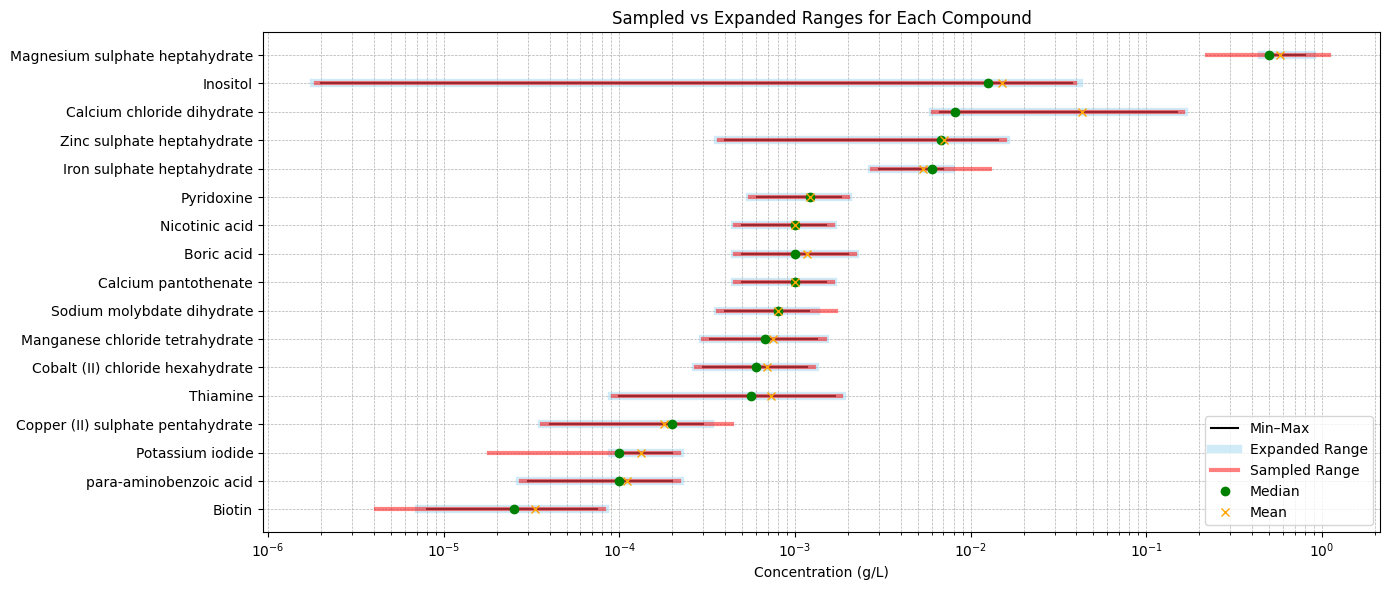

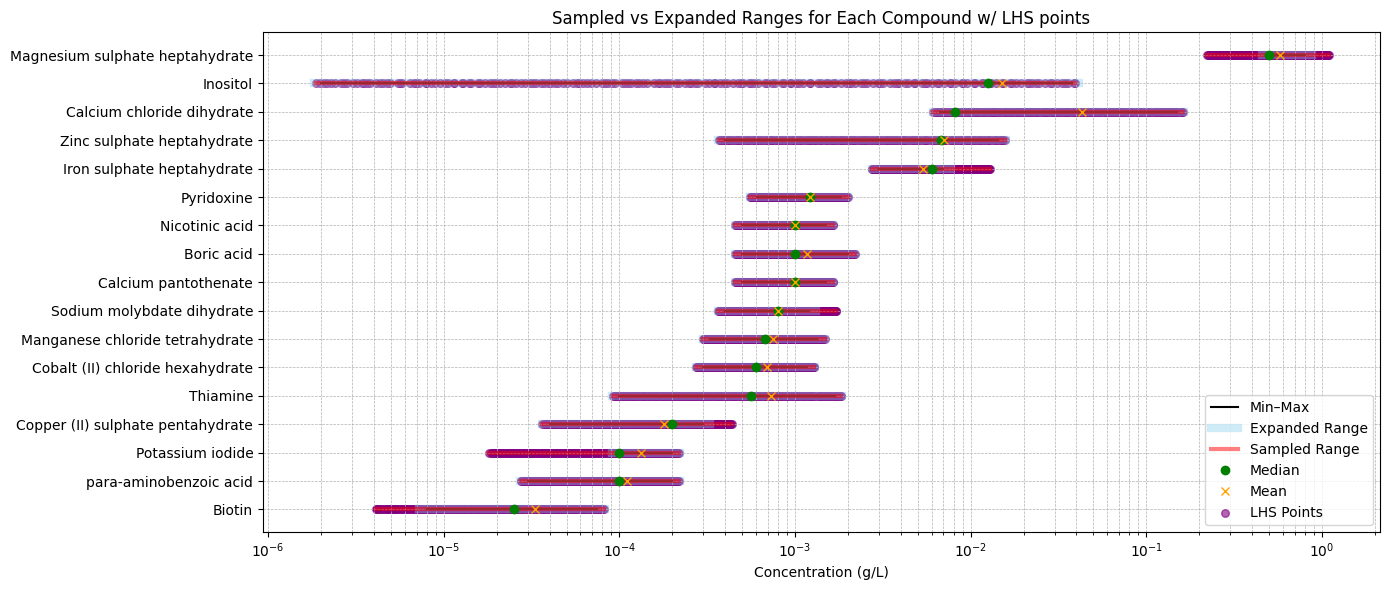

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_26172\764608439.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab20", n_samples)  # distinct color per LHS sample


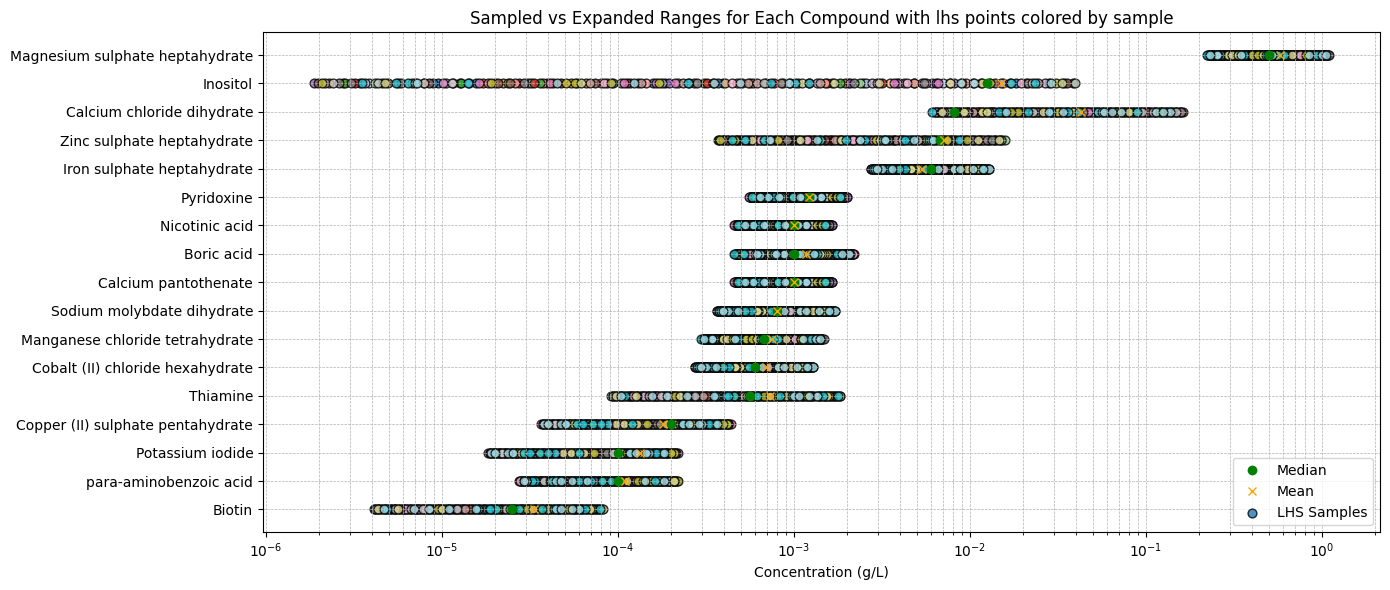

In [25]:
# Decode all LHS or BO points
decoded_samples = [
    decode_bo_sample(sample, keys, scaler_map, pd.concat([df_v_min_max, df_e_min_max]))
    for sample in scaled_lhs_design
]

# Plot
plot_sampled_vs_expanded(
    decoded_samples,
    df_min_max=pd.concat([df_v_min_max, df_e_min_max]),
    title="Sampled vs Expanded Ranges for Each Compound"
)

# Plot
plot_sampled_vs_expanded_with_points(
    decoded_samples,
    df_min_max=pd.concat([df_v_min_max, df_e_min_max]),
    title="Sampled vs Expanded Ranges for Each Compound w/ LHS points"
)

plot_sampled_vs_expanded_lhs_on_top(
    decoded_samples,
    df_min_max=pd.concat([df_v_min_max, df_e_min_max]),
    title="Sampled vs Expanded Ranges for Each Compound with lhs points colored by sample"
)

In [26]:
def build_sample_matrix(decoded_samples, compound_order=None):
    """
    Builds a DataFrame of decoded samples (g/L) with samples as rows, compounds as columns.

    Args:
        decoded_samples (list of dict): Output from decode_bo_sample for each point.
        compound_order (list, optional): To enforce a specific column order.

    Returns:
        pd.DataFrame: Rows = samples, Columns = compound names
    """
    df = pd.DataFrame(decoded_samples)
    if compound_order:
        df = df[compound_order]  # reorder columns
    return df

In [27]:
# Decode samples if not done yet
decoded_samples = [
    decode_bo_sample(sample, keys, scaler_map, pd.concat([df_v_min_max, df_e_min_max]))
    for sample in scaled_lhs_design
]

# Create sample matrix
compound_order = sorted(decoded_samples[0].keys())  # or use custom order
sample_matrix_df = build_sample_matrix(decoded_samples, compound_order)

# Optional: Add comment row for units (will be skipped by pandas when loading)
units_row = pd.DataFrame([["g/L"] * sample_matrix_df.shape[1]], columns=sample_matrix_df.columns)
final_df = pd.concat([units_row, sample_matrix_df], ignore_index=True)

# Export
final_df.to_csv("bo_samples_compound_matrix_191.csv", index=False)


In [28]:
# this creates the file in the transposed for that makes it easy to conver to the file that JULIA expects, with compounds as rows and samples as columns

# manual processing is required here as you have to ensure you know the ratio values and pick the representative compound for each cluster.

def export_samples_transposed(decoded_samples, filename="bo_samples_transposed.csv"):
    """
    Save decoded samples with compounds as rows and samples as columns.
    """
    # Turn into DataFrame
    df = pd.DataFrame(decoded_samples)

    # Transpose so compounds are rows, samples are columns
    df_t = df.T
    df_t.columns = [f"Sample_{i+1}" for i in range(df_t.shape[1])]
    df_t.insert(0, "Compound", df_t.index)

    # Optional: add units row
    units_row = pd.DataFrame([["g/L"] + [""] * (df_t.shape[1] - 1)], columns=df_t.columns)

    # Combine and export
    df_final = pd.concat([units_row, df_t], ignore_index=True)
    df_final.to_csv(filename, index=False)

In [29]:
export_samples_transposed(
    decoded_samples,
    filename="bo_samples_compoundwise_191.csv"
)

In [23]:
def get_max_concentrations_from_bo_bounds(bo_bounds, scaler_map):
    """
    Computes the maximum concentration (g/L) each compound can reach based on bo_bounds.

    Args:
        bo_bounds (dict): keys are either cluster names or individual compounds, values are (min, max) tuples in log10/alpha space
        scaler_map (dict): maps cluster names to their ClusterScaler instances

    Returns:
        pd.DataFrame with compound-level max concentration values
    """
    rows = []

    for key, (min_val, max_val) in bo_bounds.items():
        if key in scaler_map:
            # Cluster key → decode using alpha
            decoded = scaler_map[key].concentration_from_alpha(max_val)
            for compound, conc in decoded.items():
                rows.append({
                    "Compound": compound,
                    "Max_Concentration (g/L)": conc,
                    "Source": f"{key} (alpha_max)"
                })
        else:
            # Individual compound → log10-transformed
            conc = 10 ** max_val
            rows.append({
                "Compound": key,
                "Max_Concentration (g/L)": conc,
                "Source": "individual (log10 max)"
            })

    df_max = pd.DataFrame(rows).sort_values("Compound").reset_index(drop=True)
    return df_max


In [24]:
df_max_conc = get_max_concentrations_from_bo_bounds(bo_bounds, scaler_map)
df_max_conc.to_csv("bo_max_concentrations_per_compound.csv", index=False)

In [31]:
print(df_v_min_max)
print(df_e_min_max)

                  Compound       Min       Max    Median      Mean  \
5                   Biotin  0.000008  0.000075  0.000025  0.000033   
61  para-aminobenzoic acid  0.000030  0.000200  0.000100  0.000110   
23                Inositol  0.000002  0.037500  0.012500  0.015001   
43              Pyridoxine  0.000608  0.001823  0.001216  0.001216   
36          Nicotinic acid  0.000500  0.001500  0.001000  0.001000   
6               Boric acid  0.000500  0.002000  0.001000  0.001167   
8     Calcium pantothenate  0.000500  0.001500  0.001000  0.001000   
52                Thiamine  0.000100  0.001682  0.000561  0.000733   

    Expanded_Min  Expanded_Max  
5       0.000007      0.000083  
61      0.000027      0.000220  
23      0.000002      0.041250  
43      0.000553      0.002006  
36      0.000455      0.001650  
6       0.000455      0.002200  
8       0.000455      0.001650  
52      0.000091      0.001850  
                             Compound       Min       Max    Median     